# Poverty Prediction from County Census Data -- PySpark
In this project, I will perform regression analysis of the county-wide Census to predict poverty rate in counties in the United States. This work has already performed using the linear regression algorithms with *sklearn* library [link](https://github.com/chauvu/chauvu.github.io/blob/main/Notebooks/census_regression.ipynb). Here, instead of *sklearn*, I will use *PySpark*, which is the Python interface for Apache Spark. Spark is a popular open-sourced framework for distributed programming (using different nodes across different machines). In industry, Spark is usually run on top of a Hadoop cluster with Hadoop's YARN to perform work allocation across nodes. In this project, however, I will be running Spark locally on my laptop.

Mostly, I will be using the two most commonly used Spark features - DataFrames and SparkSQL. I will not use directly using RDDs, which are the data structure distributed across nodes; however, DataFrames are built on RDDs but have a similar usage to *pandas*' DataFrames, so it is more convenient for implementation. Other interesting features of Spark include MLLib (which can be used for training deep learning models) and GraphX/GraphFrames (which can be used for graph analysis); these can potentially be explored in future projects.

In this current work, I will be repeating the linear regression on Census found in [link](https://github.com/chauvu/chauvu.github.io/blob/main/Notebooks/census_regression.ipynb) using the native Spark's DataFrames features. 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import pyspark.sql.functions as F
from pyspark.sql.types import StructField, StructType, StringType, IntegerType, FloatType
from pyspark.sql import SparkSession

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, VectorIndexer, MinMaxScaler, StandardScaler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml.stat import Correlation

### Spark Initialization
I need to first start a Spark context. Since I am not running on top of node cluster across different machines, I will set the context to *local*. And since my machine has 4 cores, I will create 4 worker nodes with `local[4]`.

In [2]:
spark = SparkSession.builder.master("local[4]").appName('Health_County').getOrCreate() # 4 cores
sc = spark.sparkContext

## Data Exploratory Analysis
Data has already been cleaned in a previous [project](https://github.com/chauvu/chauvu.github.io/blob/main/Notebooks/census_data_cleaning.ipynb). Here, I will be loading in the data pickle file from [here](https://github.com/chauvu/chauvu.github.io/blob/main/Data/census/data_census.pkl).

When `spark.createDataFrame` is called upon a pandas DataFrame, it can interpret and guess the schema of data types. However, it is always better to explicitly specify the schema for DataFrames. For example, I have explicitly specified that `FIPS`, `State` and `County_Name` are string types, whereas the rest of the columns are either interger or float types. The schema can be shown below.

I am also showing the 1st entry of the Spark DataFrame using `df.show(1)`. However, since there are many columns, the display is overrun and difficult to see. It is much harder to interpret compared with the convenient and simple display by using pandas `data.head(1)`. However, the point of spark is not for viewing individual data entries. Spark expedites analysis on data distributed across different machines, so the strength of Spark is in the data analytics not data visualization.

In [3]:
data = pd.read_pickle('data_census.pkl')
schema_list = []
for c in data.columns:
	if c in ['FIPS', 'State', 'County_Name']:
		schema_list.append(StructField(c, StringType(), nullable=True))
	elif c in ['CENSUS_2010_POP', 'FIPS_int', 'ABS_POVERTY', 'ABS_POVERTY_CHILDREN', 'MEDIAN_HH_INCOME', 'Metropolitan']:
		schema_list.append(StructField(c, IntegerType(), nullable=True))
	else:
		schema_list.append(StructField(c, FloatType(), nullable=True))
schema = StructType(schema_list)
df = spark.createDataFrame(data, schema=schema) # explicit schema

In [4]:
df.printSchema()

root
 |-- FIPS: string (nullable = true)
 |-- State: string (nullable = true)
 |-- County_Name: string (nullable = true)
 |-- CENSUS_2010_POP: integer (nullable = true)
 |-- FIPS_int: integer (nullable = true)
 |-- AVE_POP_CHG: float (nullable = true)
 |-- AVE_BIRTHS: float (nullable = true)
 |-- AVE_DEATHS: float (nullable = true)
 |-- AVE_INTERNATIONAL_MIG: float (nullable = true)
 |-- AVE_DOMESTIC_MIG: float (nullable = true)
 |-- ABS_POVERTY: integer (nullable = true)
 |-- PERCENT_POVERTY: float (nullable = true)
 |-- ABS_POVERTY_CHILDREN: integer (nullable = true)
 |-- PERCENT_POVERTY_CHILDREN: float (nullable = true)
 |-- MEDIAN_HH_INCOME: integer (nullable = true)
 |-- Metropolitan: integer (nullable = true)
 |-- Med_HH_Income: float (nullable = true)
 |-- Median_HH_Income_pct_state: float (nullable = true)
 |-- Ave_Unemployed_Rate: float (nullable = true)
 |-- LT_HighSchool: float (nullable = true)
 |-- HighSchool: float (nullable = true)
 |-- Associate: float (nullable = true)

In [5]:
# spark
df.show(1)

+-----+-----+--------------+---------------+--------+-----------+----------+----------+---------------------+----------------+-----------+---------------+--------------------+------------------------+----------------+------------+-------------+--------------------------+-------------------+-------------+----------+---------+-----------+---------------------+------------------+-----------------+-------------------+--------------------+---------------------+--------------+------------------+
| FIPS|State|   County_Name|CENSUS_2010_POP|FIPS_int|AVE_POP_CHG|AVE_BIRTHS|AVE_DEATHS|AVE_INTERNATIONAL_MIG|AVE_DOMESTIC_MIG|ABS_POVERTY|PERCENT_POVERTY|ABS_POVERTY_CHILDREN|PERCENT_POVERTY_CHILDREN|MEDIAN_HH_INCOME|Metropolitan|Med_HH_Income|Median_HH_Income_pct_state|Ave_Unemployed_Rate|LT_HighSchool|HighSchool|Associate|Bachelor_GT|Percent_LT_HighSchool|Percent_HighSchool|Percent_Associate|Percent_Bachelor_GT|Heart_mortality_rate|Stroke_mortality_rate|AVE_BIRTH_RATE|Percent_High_Speed|
+-----+---

In [6]:
# pandas
data.head(1)

,FIPS,State,County_Name,CENSUS_2010_POP,FIPS_int,AVE_POP_CHG,AVE_BIRTHS,AVE_DEATHS,AVE_INTERNATIONAL_MIG,AVE_DOMESTIC_MIG,...,Associate,Bachelor_GT,Percent_LT_HighSchool,Percent_HighSchool,Percent_Associate,Percent_Bachelor_GT,Heart_mortality_rate,Stroke_mortality_rate,AVE_BIRTH_RATE,Percent_High_Speed
0,01001,AL,Autauga County,54571,1001,105.875,637.0,550.5,4.0,16.875,...,10552.0,10291.0,11.3,32.6,28.4,27.7,425.0,96.5,34.31875,0.75


### PySpark DataFrames vs. SparkSQL commands
Spark DataFrames have various commands to manipulate the data, many of which have parallel in the Spark's implementation of SQL. Here, I display a few common commands and demonstrate that both techniques yield the same results.

As we can see, the results are the same, but the code for Spark SQL tend to be more *verbose* because it needs to translate a longer SQL command into Spark DataFrames command. However, the advantage of using SparkSQL is that SQL is a very universal language that most people are proficient at, so this eliminates the need to memorizing additional Spark DataFrame syntax when Spark SQL can take care of it behind the scene for you.

In [7]:
# Spark SQL
print('Spark SQL')
df.createOrReplaceTempView('data')
result = spark.sql("SELECT CENSUS_2010_POP FROM data LIMIT 10")
result.show()

# Spark DataFrames
print('Spark DataFrames')
df.select('CENSUS_2010_POP').show(10)

Spark SQL
+---------------+
|CENSUS_2010_POP|
+---------------+
|          54571|
|         182265|
|          27457|
|          22915|
|          57322|
|          10914|
|          20947|
|         118572|
|          34215|
|          25989|
+---------------+

Spark DataFrames
+---------------+
|CENSUS_2010_POP|
+---------------+
|          54571|
|         182265|
|          27457|
|          22915|
|          57322|
|          10914|
|          20947|
|         118572|
|          34215|
|          25989|
+---------------+
only showing top 10 rows



In [8]:
# Spark SQL
print('Spark SQL')
result = spark.sql("SELECT State, AVG(CENSUS_2010_POP) death FROM data GROUP BY State ORDER BY death LIMIT 10")
result.show()

# Spark DataFrames
print('Spark DataFrames')
df.groupby('State').agg(F.avg('CENSUS_2010_POP').alias('death')).orderBy('death').show(10)

Spark SQL
+-----+------------------+
|State|             death|
+-----+------------------+
|   SD|        12493.5625|
|   ND|13093.333333333334|
|   MT|         17668.125|
|   NE| 21091.45348837209|
|   WY|24505.478260869564|
|   KS|27412.346153846152|
|   IA|30771.262626262625|
|   WV|           33690.8|
|   ID| 35626.86363636364|
|   KY| 36161.39166666667|
+-----+------------------+

Spark DataFrames
+-----+------------------+
|State|             death|
+-----+------------------+
|   SD|        12493.5625|
|   ND|13093.333333333334|
|   MT|         17668.125|
|   NE| 21091.45348837209|
|   WY|24505.478260869564|
|   KS|27412.346153846152|
|   IA|30771.262626262625|
|   WV|           33690.8|
|   ID| 35626.86363636364|
|   KY| 36161.39166666667|
+-----+------------------+
only showing top 10 rows



In [9]:
# Spark SQL
print('Spark SQL')
result = spark.sql("SELECT State, AVG(CENSUS_2010_POP) death, \
					(CASE WHEN AVG(CENSUS_2010_POP) > 500 THEN 'HIGH' ELSE 'LOW' END) AS rate \
					FROM data GROUP BY State \
					ORDER BY death LIMIT 10")
result.show()

# Spark DataFrames
print('Spark DataFrames')
df.groupby('State').agg(F.avg('CENSUS_2010_POP').alias('death'), F.when(F.avg('CENSUS_2010_POP')>500, 'HIGH').otherwise('LOW').alias('rate')).orderBy('death').show(10)


Spark SQL
+-----+------------------+----+
|State|             death|rate|
+-----+------------------+----+
|   SD|        12493.5625|HIGH|
|   ND|13093.333333333334|HIGH|
|   MT|         17668.125|HIGH|
|   NE| 21091.45348837209|HIGH|
|   WY|24505.478260869564|HIGH|
|   KS|27412.346153846152|HIGH|
|   IA|30771.262626262625|HIGH|
|   WV|           33690.8|HIGH|
|   ID| 35626.86363636364|HIGH|
|   KY| 36161.39166666667|HIGH|
+-----+------------------+----+

Spark DataFrames
+-----+------------------+----+
|State|             death|rate|
+-----+------------------+----+
|   SD|        12493.5625|HIGH|
|   ND|13093.333333333334|HIGH|
|   MT|         17668.125|HIGH|
|   NE| 21091.45348837209|HIGH|
|   WY|24505.478260869564|HIGH|
|   KS|27412.346153846152|HIGH|
|   IA|30771.262626262625|HIGH|
|   WV|           33690.8|HIGH|
|   ID| 35626.86363636364|HIGH|
|   KY| 36161.39166666667|HIGH|
+-----+------------------+----+
only showing top 10 rows



## Data Cleaning
In this part, I will repeat some basic data cleaning processes performed in [link](https://github.com/chauvu/chauvu.github.io/blob/main/Notebooks/census_data_cleaning.ipynb). 
* Drop unnecessary columns, such as `FIPS` which is the numerical code for different counties.
* Compute informative columns, such as `Pop_change_rate` as the rate of change of the population of this county.
* Identify columns with null values. The table printed below shows the only column with null value is `Percent_High_Speed` with 210 rows that are null.
* Mean imputation, performed on `Percent_High_Speed` by replacing the mean value into all null entries.
* Round to 2 decimals (for display purposes). This portion makes use of user-defined functions in Spark DataFrames and applied it on columns in the DataFrame. As shown below, we have rounded the values to 2 decimals, which make it much easier for display purposes.

In [10]:
# drop unnecessary columns
df = df.drop('FIPS','State','County_Name','FIPS_int','PERCENT_POVERTY_CHILDREN',\
			'ABS_POVERTY_CHILDREN','ABS_POVERTY','MEDIAN_HH_INCOME','Med_HH_Income',\
			'LT_HighSchool', 'HighSchool', 'Associate', 'Bachelor_GT')
# add new columns
df = df.withColumn('Pop_change_rate', df['AVE_POP_CHG'] / df['CENSUS_2010_POP'])
df = df.withColumn('Death_rate', df['AVE_DEATHS'] / df['CENSUS_2010_POP'])
df = df.withColumn('Intl_migration_rate', df['AVE_INTERNATIONAL_MIG'] / df['CENSUS_2010_POP'])
df = df.withColumn('Domestic_migration_rate', df['AVE_DOMESTIC_MIG'] / df['CENSUS_2010_POP'])
df = df.drop('AVE_POP_CHG','AVE_DEATHS','AVE_BIRTHS','AVE_INTERNATIONAL_MIG','AVE_DOMESTIC_MIG')

# check nan values
for c in df.columns:
	table = df.select(F.count(F.when(F.isnan(c), c)).alias(c))
	row = table.first()
	row_value = list(row.asDict().values())[0]
	if row_value > 0:
		table.show()

+------------------+
|Percent_High_Speed|
+------------------+
|               210|
+------------------+



In [11]:
# mean imputation
stats = df.where(~F.isnan(F.col("Percent_High_Speed"))).agg(F.avg('Percent_High_Speed').alias('Percent_High_Speed'))
stats_mean = list(stats.first().asDict().values())[0]
df = df.na.fill(stats_mean, ['Percent_High_Speed'])

In [12]:
# round to 2 decimals with UDF
def round_2dec(x):
	return round(x, 2)
round_2dec_udf = F.udf(lambda z: round_2dec(z), FloatType())

In [13]:
df_round = df.select([round_2dec_udf(F.col(c)).alias(c) for c in df.columns])

In [14]:
df_round.show(1)

+---------------+---------------+------------+--------------------------+-------------------+---------------------+------------------+-----------------+-------------------+--------------------+---------------------+--------------+------------------+---------------+----------+-------------------+-----------------------+
|CENSUS_2010_POP|PERCENT_POVERTY|Metropolitan|Median_HH_Income_pct_state|Ave_Unemployed_Rate|Percent_LT_HighSchool|Percent_HighSchool|Percent_Associate|Percent_Bachelor_GT|Heart_mortality_rate|Stroke_mortality_rate|AVE_BIRTH_RATE|Percent_High_Speed|Pop_change_rate|Death_rate|Intl_migration_rate|Domestic_migration_rate|
+---------------+---------------+------------+--------------------------+-------------------+---------------------+------------------+-----------------+-------------------+--------------------+---------------------+--------------+------------------+---------------+----------+-------------------+-----------------------+
|           null|           13.8|    

## Data Analysis
The purpose of this project is to analyze the dependency of countywide poverty rates with different factors in the census dataset. Let's take a look at univariate correlation coefficients between these predictors with `PERCENT_POVERTY`. We can see that median household incomes tend to have negative correlation with poverty, whereas average birth rate is positively correlated with poverty.

You can find this exact same figure created using *pandas* and *sklearn* in the previous [project](https://github.com/chauvu/chauvu.github.io/blob/main/Notebooks/census_regression.ipynb).

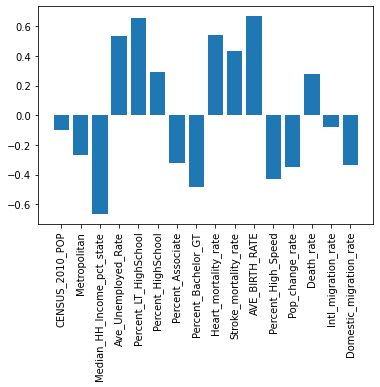

In [15]:
corrs = {}
for c in df.columns:
	if c=='PERCENT_POVERTY': continue
	else:
		corrs[c] = df.corr(c, 'PERCENT_POVERTY')
plt.bar(list(corrs.keys()), list(corrs.values()))
plt.xticks(rotation=90)
plt.show()

I split the data into the training and testing sets (80/20) and created `feature_list` variable to hold all predictors. Next, I will perform linear regression using two methods:
* Elastic Net Regularization
* Random Forest Regression

Additionally, the categorical data `Metropolitan` has already been indexed (0 for not metropolitan and 1 for metropolitan); therefore, does not need pipeline with `VectorIndexer`. Otherwise, I will need to add it to the beginning of the pipeline <VectorIndexer, VectorAssembler, linear_regression>.

In [16]:
df_train, df_test = df.randomSplit([0.8, 0.2], seed=123)
label_col = 'PERCENT_POVERTY'
feature_list = [c for c in df.columns if c != label_col]
feature_list

['CENSUS_2010_POP',
 'Metropolitan',
 'Median_HH_Income_pct_state',
 'Ave_Unemployed_Rate',
 'Percent_LT_HighSchool',
 'Percent_HighSchool',
 'Percent_Associate',
 'Percent_Bachelor_GT',
 'Heart_mortality_rate',
 'Stroke_mortality_rate',
 'AVE_BIRTH_RATE',
 'Percent_High_Speed',
 'Pop_change_rate',
 'Death_rate',
 'Intl_migration_rate',
 'Domestic_migration_rate']

### 1. Elastic Net Regression
Here, I use linear regression with Elastic Net, with `elasticNetParam=0.5`, which means it has 50% weighting for L1 regularization and 50% weighting for L2 regularization. The top 20 rows for the poverty predictions are shown on the test set in comparison with ground truth `PERCENT_POVERTY` column. The R-squared value for the model is 0.69.

In [17]:
assembler = VectorAssembler(inputCols=feature_list, outputCol='features')
scaler = StandardScaler(inputCol='features', outputCol='features_scaled')
lr = LinearRegression(labelCol=label_col, featuresCol='features_scaled', regParam=0.5, elasticNetParam=0.5)
pipeline = Pipeline(stages=[assembler, scaler, lr])

In [18]:
lr_fit = pipeline.fit(df_train)
lr_preds = lr_fit.transform(df_test)
print('Results on Test Set')
lr_preds.select('prediction', label_col).show()
evaluator = RegressionEvaluator(labelCol=label_col, predictionCol='prediction', metricName='r2')
r2 = evaluator.evaluate(lr_preds)

Results on Test Set
+------------------+---------------+
|        prediction|PERCENT_POVERTY|
+------------------+---------------+
|12.077167609430536|            8.6|
| 12.30130096807471|           13.4|
|15.785971380675178|           14.9|
|14.538850406670642|           10.5|
|23.064992510196284|           29.8|
|13.646875218405668|           14.2|
|19.802415176866788|           20.0|
|11.944794795452998|           14.7|
|17.141955764093154|           18.6|
|12.624131580702194|           13.7|
|20.495783900801644|           22.0|
| 15.14408719572752|           13.8|
| 16.45456556793397|           15.7|
|10.090685389236505|           10.7|
|19.907120757898213|           33.9|
|21.670687627686043|           24.8|
|24.072271986759393|           30.8|
|17.620601058129434|           17.2|
|18.911092520949783|           21.4|
| 17.52732751674819|           15.8|
+------------------+---------------+
only showing top 20 rows



In [19]:
r2

0.6904765391168665

Since Elastic Net includes an L1 regularization component, it can aid in feature selection process, as predictors that do not have a lot of influence on the poverty prediction will be ~0. Therefore, from the regression coefficients, we can deduct that only 10 features significantly impact poverty:
* Median household income
* Average unemployment rate
* Percent of less than high school graduates
* Percent at least high school graduates
* Percent at least associate degrees
* Heart / Stroke mortality rate
* Average birth rates
* Percentage with high speed internet
* Domestic migration rates

In [20]:
lr_coef = lr_fit.stages[2].coefficients
pd.Series(dict(zip(feature_list, lr_coef)))

CENSUS_2010_POP               0.000000
Metropolitan                  0.000000
Median_HH_Income_pct_state   -2.206340
Ave_Unemployed_Rate           0.893559
Percent_LT_HighSchool         0.560696
Percent_HighSchool           -0.285622
Percent_Associate            -0.732889
Percent_Bachelor_GT           0.000000
Heart_mortality_rate          0.558981
Stroke_mortality_rate         0.275716
AVE_BIRTH_RATE                1.342752
Percent_High_Speed           -0.305116
Pop_change_rate               0.000000
Death_rate                    0.000000
Intl_migration_rate           0.000000
Domestic_migration_rate      -0.191457
dtype: float64

### 2. Random Forest Regression
Next, I will use a random forest regressor. Below, we can see the top 20 rows for the test predictions and the final R-squared values is 0.71, which is comparable to our results by using *sklearn* for random forest regression.

In [21]:
assembler = VectorAssembler(inputCols=feature_list, outputCol='features')
scaler = StandardScaler(inputCol='features', outputCol='features_scaled')
rf = RandomForestRegressor(labelCol=label_col, featuresCol='features_scaled') # numTrees, maxDepth
pipeline = Pipeline(stages=[assembler, scaler, rf])

In [22]:
rf_fit = pipeline.fit(df_train)
rf_preds = rf_fit.transform(df_test)
print('Results on Test Set')
rf_preds.select('prediction', label_col).show()
evaluator = RegressionEvaluator(labelCol=label_col, predictionCol='prediction', metricName='r2')
r2 = evaluator.evaluate(rf_preds)

Results on Test Set
+------------------+---------------+
|        prediction|PERCENT_POVERTY|
+------------------+---------------+
|12.811096090163321|            8.6|
|13.182017767432583|           13.4|
|13.806131381871442|           14.9|
|13.159843513444034|           10.5|
|26.084354056426168|           29.8|
|12.561470145737784|           14.2|
| 23.92612006896507|           20.0|
|12.288581529224185|           14.7|
|17.785443085458265|           18.6|
|13.595226643542631|           13.7|
| 21.11322164568127|           22.0|
| 16.25391336463381|           13.8|
|15.653683782118344|           15.7|
|10.644535776747139|           10.7|
|23.195428410271656|           33.9|
| 25.80539220398316|           24.8|
|27.594140710037227|           30.8|
| 16.09047657405191|           17.2|
| 17.26938585336499|           21.4|
|18.141181763541734|           15.8|
+------------------+---------------+
only showing top 20 rows



In [23]:
r2

0.7224278199100633

To ensure that we are getting the best-performing models compared to out-of-the-box models, I will now perform hyperparameter optimization on the random forest regressor. The parameter to optimize is `numTrees`, which is the number of trees in the random forest. The Spark's `ParamGridBuilder` can take more parameters to optimize, but for simplification, in this part, I will only look at number of trees, in range of [10, 30] with 3 spacing.

We can see that the R-squared value after hyperparameter tuning is not different from out of the box, and I have determined that the optimal number of trees is 30, which is the highest value within our grid search. Therefore, it is possible that if I increase the range of numTrees search, I can find even better performance.

In [24]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 30, num = 3)]) \
    .build()
rf_crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(
                          							labelCol=label_col, 
                          							predictionCol='prediction', 
                          							metricName='r2'
                          						),
                          numFolds=3)
rf_crossval_fit = rf_crossval.fit(df_train)
rf_crossval_preds = rf_crossval_fit.transform(df_test)
print('Results on Test Set with Optimal Hyperparameters')
rf_crossval_preds.select('prediction', label_col).show()
evaluator = RegressionEvaluator(labelCol=label_col, predictionCol='prediction', metricName='r2')
r2_crossval = evaluator.evaluate(rf_crossval_preds)

Results on Test Set with Optimal Hyperparameters
+------------------+---------------+
|        prediction|PERCENT_POVERTY|
+------------------+---------------+
|12.811096090163321|            8.6|
|13.182017767432583|           13.4|
|13.806131381871442|           14.9|
|13.159843513444034|           10.5|
|26.084354056426168|           29.8|
|12.561470145737784|           14.2|
| 23.92612006896507|           20.0|
|12.288581529224185|           14.7|
|17.785443085458265|           18.6|
|13.595226643542631|           13.7|
| 21.11322164568127|           22.0|
| 16.25391336463381|           13.8|
|15.653683782118344|           15.7|
|10.644535776747139|           10.7|
|23.195428410271656|           33.9|
| 25.80539220398316|           24.8|
|27.594140710037227|           30.8|
| 16.09047657405191|           17.2|
| 17.26938585336499|           21.4|
|18.141181763541734|           15.8|
+------------------+---------------+
only showing top 20 rows



In [25]:
r2_crossval

0.7224278199100633

In [26]:
rf_best = rf_crossval_fit.bestModel
rf_feature_importance = rf_best.stages[2].featureImportances
rf_best_numTrees = rf_best.stages[2].getOrDefault('numTrees')
rf_best_numTrees

20

Finally, the advantage of using random forest is that we can determine *feature importance*, which indicates how much impact a certain predictor has on the outcome. From the plot below, I can identify 3 most salient features:
* Median household income
* Percent of less than high school graduates
* Average birth rates

Therefore, if we want to improve performance by reducing variance, we can perform linear regression again, whether with elastic net or random forest, using only these 3 features and compare the adjusted R-squared results.

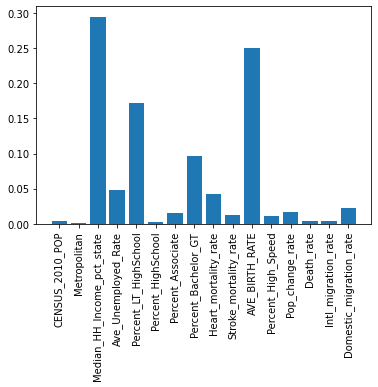

In [27]:
plt.bar(feature_list, list(rf_feature_importance))
plt.xticks(rotation=90)
plt.show()

In [28]:
spark.stop()

# Conclusion

In conclusion, in this work, I repeat the [data cleaning](https://github.com/chauvu/chauvu.github.io/blob/main/Notebooks/census_data_cleaning.ipynb) and [linear regression analysis](https://github.com/chauvu/chauvu.github.io/blob/main/Notebooks/census_regression.ipynb) on 15 years of countywide census data. I can demonstrate similar performance between using *PySpark* and *sklearn* libraries. Currently, I am not seeing any reduction in time or resources in using PySpark, but it is likely that this dataset is too small. Even though I am taking advantage of 4 different worker nodes on my local computer, sklearn is probably more efficient in analyzing small dataset only on 1 node, whereas Spark needs the additional time to pass information between nodes, which is only good for very very large datasets that do not fit into one processing node on one machine.